# Solving the Boltzman equation for DM Freeze-In

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpmath 

## Usefull constants

In [2]:
m_e=0.511 #Mev
m_mu=105.658 #Mev
m_tau=1776.86 #Mev
m_charge=[m_e,m_mu,m_tau]
pi=np.pi
G = 6.71*10**-45 # MeV
Mpl = (8 * pi * G) ** (-0.5)
yinf=4.35*10**-7 # Divided by the mass of the particle
y0=0.0
geff=3

## Import $g_{*s}$

In [3]:
data = np.loadtxt('g_*s(T).txt', skiprows=1)
t_imported = data[:, 0]
g_star_s_imported = data[:, 1]
def g_star_s_interp_func(t):
    return sp.interpolate.interp1d(t_imported, g_star_s_imported, fill_value="extrapolate")(t)


## Math functions

In [4]:
def bk(n,x):
    return sp.special.kn(n,x)

def gmeijer1(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [1]], [[-1/2, -1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

def gmeijer2(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [2]], [[-1/2, 1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

## Number density of massive fermions

In [5]:
def int_n_e(E, m, T):
    arg = E / T
    arg = np.clip(arg, None, 700)  # Avoid overflow in exp
    return E * np.sqrt(E**2 - m**2) / (np.exp(arg) + 1)

def n_e(m,T,glib):
    int=[]
    if m>0:
        int.append(sp.integrate.quad(int_n_e,m,m*10,args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,m*10**(i+1),m*10**(i+2),args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    elif m==0:
        int.append(sp.integrate.quad(int_n_e,0,1,args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,10**i,10**(i+1),args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    else:
        print('Error: Negative mass')
        return 0
    

## Thermodinamical properties of "massless" fermions

In [6]:
def n_nu(T,glib):                                              # If Dirac fermions glib=4
    return 3*glib*sp.special.zeta(3)*T**3/(4*np.pi**2)         # If Majorana fermions glib=2 

def rho_nu(T,glib):                                                 # If Dirac fermions glib=4
    return (7*glib*np.pi**2*T**4)/(240)                        # If Majorana fermions glib=2 

def p_nu(T,glib):
    return (1/3)*rho_nu(T,glib)

def s_nu(T,glib):
    return (4*rho_nu(T,glib))/(3*T)

def Y_nu(T,glib):
    return n_nu(T,glib)/s_nu(T,glib)    

## Electron functions

$$ \sigma=\frac{g^2}{16\pi s^3}\sqrt{\frac{s-4m_\chi^2}{s-4m_e^2}}\left[s^2+\frac{(s-4m_e^2)(s-4m_\chi^2)}{3}+4m_\chi^2(s-2m_e^2)+4m_e^2(s-2m_\chi^2)+16m_e^2m_\chi^2    \right]$$

$$<\sigma v>=\frac{1}{8 m_\chi^4 T K_2^2(m_\chi/T)}\int_{4\text{max}(m_e^2,m_\chi^2)}^\infty ds\; \sigma(s-4m_\chi^2)\sqrt{s}K_1(\sqrt{s}/T) $$

$$ \frac{dY_e}{dx}=\frac{2<\sigma v>_en_e^2}{xHs}$$

In [7]:
def sigma_e(s,g,mchi,me):
    sigma1=g**2/(16*pi*s**3)
    sigma2=np.sqrt((s-4*mchi**2)/(s-4*me**2))
    sigma31=(s**2+((s-4*me**2)*(s-4*mchi**2))/(3))
    sigma32=4*mchi**2*(s-2*me**2)
    sigma33=4*me**2*(s-2*mchi**2)
    sigma34=16*mchi**2*me**2
    return sigma1*sigma2*(sigma31+sigma32+sigma33+sigma34)

def intsigma_e(s,g,mchi,T,me):
    intsigma1=sigma_e(s,g,mchi,me)
    intsigma2=(s-4*mchi**2)
    intsigma3=np.sqrt(s)
    intsigma4=bk(1,np.sqrt(s)/T)
    return intsigma1*intsigma2*intsigma3*intsigma4

def sigmav_e(g,mchi,T,me):
    int=[]
    n=50
    for i in range(n):
        int.append(sp.integrate.quad(intsigma_e,2**(2*i+2)*max(mchi**2,me**2),2**(2*i+4)*max(mchi**2,me**2),args=(g,mchi,T,me),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int.append(sp.integrate.quad(intsigma_e,2**(2*n+3)*max(mchi**2,me**2),np.inf,args=(g,mchi,T,me),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int2=np.sum(int)
    if int2==0.0:
        #print("Warning: sigmav_e is zero, returning 0")
        return 0.0
    c1=8*mchi**4*T*bk(2,mchi/T)**2
    return (int2)/c1


In [8]:
def dYdx_e(y,x,g,mchi,me):
    a1=sigmav_e(g,mchi,mchi/x,me)
    a2=n_e(me,mchi/x,4)
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

## EDO Solvers

In [9]:
mchi=[0.01,0.1,1,10,100]
x=np.logspace(-8,2,5000)
g_charge=[5.595983880520554e-12,1.767473984843161e-12,9.717214249235591e-13,9.641710764685444e-13,1.1339032334744303e-12]
temp=[]
yplot_e=[]
yplot_mu=[]
yplot_tau=[]
yplot_total=[]
for i in range(len(mchi)):
    temp=[]
    for j in range(len(m_charge)):
        y_charge=sp.integrate.odeint(dYdx_e, y0, x,args=(g_charge[i],mchi[i],m_charge[j]), rtol=1e-12, atol=1e-12, mxstep=10000)
        temp.append(y_charge)
    yplot_total.append(np.sum(temp, axis=0))
    yplot_e.append(temp[0])
    yplot_mu.append(temp[1])
    yplot_tau.append(temp[2])


### Final yield

In [10]:
for i in range(len(mchi)):
    print("----------------------------------------------------------")
    print("m_chi=",mchi[i],"MeV")
    print("g_C= ",g_charge[i])
    print("Final yield for charged leptons = ",yplot_total[i][-1])
    print("----------------------------------------------------------")

----------------------------------------------------------
m_chi= 0.01 MeV
g_C=  5.595983880520554e-12
Final yield for charged leptons =  [4.34765622e-05]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 0.1 MeV
g_C=  1.767473984843161e-12
Final yield for charged leptons =  [4.34823312e-06]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 1 MeV
g_C=  9.717214249235591e-13
Final yield for charged leptons =  [4.3491379e-07]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 10 MeV
g_C=  9.641710764685444e-13
Final yield for charged leptons =  [4.34824297e-08]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 100 MeV
g_C=  1.1339032334744303e-12
Final yield for charged leptons =  [4.34572412e-

### Plot of the Yield

In [11]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})

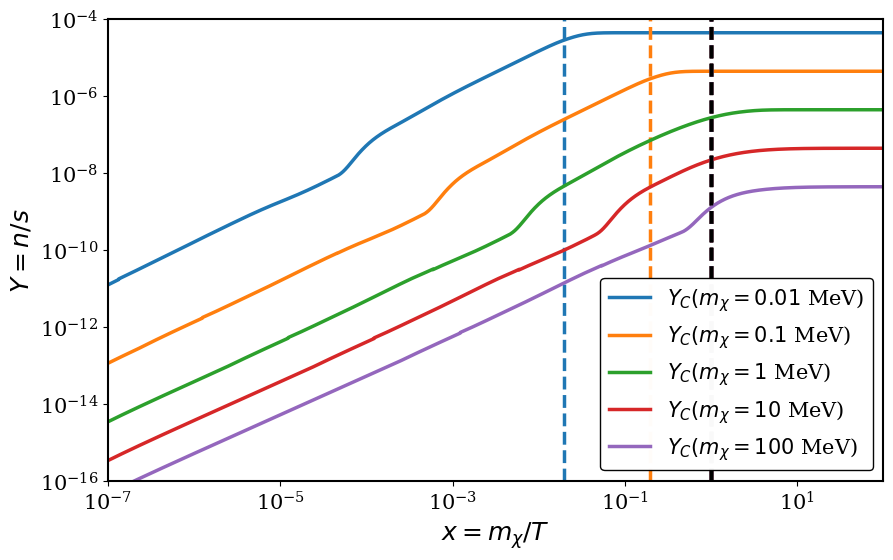

In [20]:
# Plot of one component for all masses of mchi
plt.figure(figsize=(10, 6))
for i in range(len(mchi)):
    plt.plot(x, yplot_total[i], label=fr'$Y_C(m_\chi={mchi[i]}$ MeV)')
    plt.axvline(x=mchi[i]/max(mchi[i],m_e), color=plt.gca().lines[-1].get_color(), linestyle='--')
    plt.axvline(x=1, color='black', linestyle='--')
    #plt.plot(x, yplot_e[i], label=fr'$Y_e(m={mchi[i]}$ MeV)')
    #plt.plot(x, yplot_mu[i], label=fr'$Y_\mu(m={mchi[i]}$ MeV)')
    #plt.plot(x, yplot_tau[i], label=fr'$Y_\tau(m={mchi[i]}$ MeV)')
plt.xlim(1e-7, 1e2)
plt.ylim(1e-16, 1e-4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$x=m_\chi/T$')
plt.ylabel(r'$Y=n/s$')
plt.legend()
plt.show()

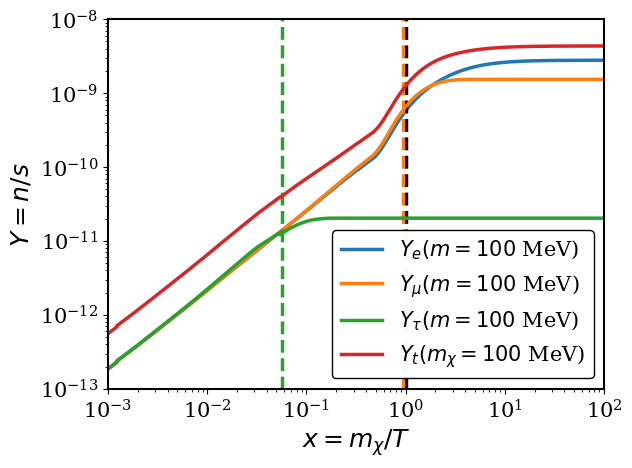

In [32]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})


# Plot of all components and one mass of mchi
mchi_selector=4
plt.plot(x, yplot_e[mchi_selector], label=fr'$Y_e(m={mchi[mchi_selector]}$ MeV)')
plt.axvline(x=1, color='black', linestyle='--')
#plt.axvline(x=mchi[mchi_selector]/m_e, color=plt.gca().lines[-1].get_color(), linestyle='--')
plt.plot(x, yplot_mu[mchi_selector], label=fr'$Y_\mu(m={mchi[mchi_selector]}$ MeV)')
plt.axvline(x=mchi[mchi_selector]/m_mu, color=plt.gca().lines[-1].get_color(), linestyle='--')
plt.plot(x, yplot_tau[mchi_selector], label=fr'$Y_\tau(m={mchi[mchi_selector]}$ MeV)')
plt.axvline(x=mchi[mchi_selector]/m_tau, color=plt.gca().lines[-1].get_color(), linestyle='--')
plt.plot(x, yplot_total[mchi_selector], label=fr'$Y_t(m_\chi={mchi[mchi_selector]}$ MeV)')

plt.xlim(1e-3,1e2)
plt.ylim(1e-13,1e-8)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$x=m_\chi/T$')
plt.ylabel(r'$Y=n/s$')
plt.legend()
plt.show()